# Упражнение 6.1


В этой главе утверждается, что analyze1 требует времени пропорционально
n^3, а analyze2 - пропорционально n^2. Убедимся в этом, запуская их с несколькими разными массивами и засекая время работы.
В блокнотах Jupyter можно использовать "волшебную команду" %timeit.
Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.
Также поупражняемся с dct_iv и scipy.fftpack.dct.

Для начала импортируем необходимые библиотеки:

In [1]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

--2024-06-13 17:30:11--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2024-06-13 17:30:11--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48574 (47K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.44K  --.-KB/s    in 0.001s  

2024-06-13 17:30:11 (47.8 MB/s) - ‘thinkdsp.py’ saved [48574/48574]



Далее создадим шумовой сигнал

In [2]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Затем создадим функцию отображения результатов анализа, которая аппроксимирует результат прямой линией:

In [3]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

Затем начнем тестирование

Результаты для analyze1:



64
555 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
2.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
256
11.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
91.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1024
359 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048
1.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
4.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.207346230268396

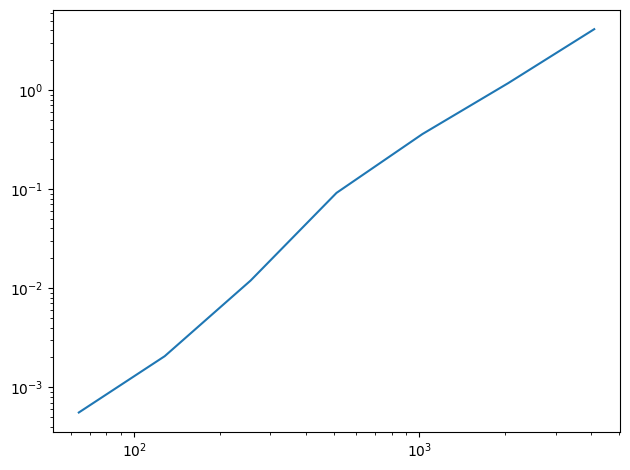

In [4]:
ns = 2 ** np.arange(6, 13)
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Однако, наклон получился близок не к 3, а к 2. Вероятно, это произошло из-за того, что в данном случае производительность np.linalg.solve близка к квадратичной

Напишем функцию для analyze2:

In [5]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Результаты для analyze2:

64
97.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
555 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
8.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
60.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
215 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
728 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1669774131226265

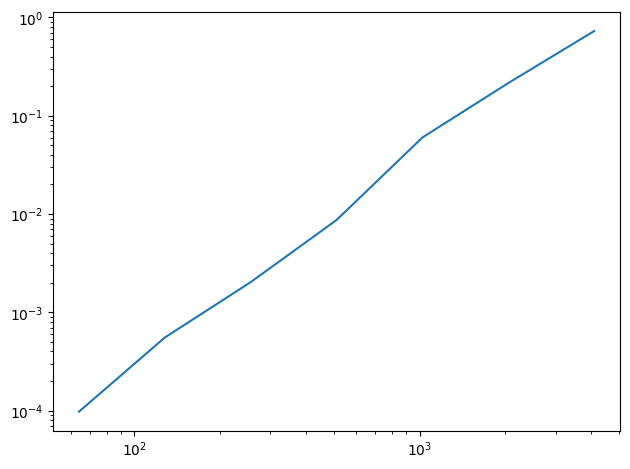

In [6]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

В итоге получили почти прямую линию с наклоном, близким к 2, как и ожидалось

Результаты тестирования scipy.fftpack.dct

64
9.63 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
7.24 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
14.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
9.87 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
21.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
35.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
64.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.4768912997233224

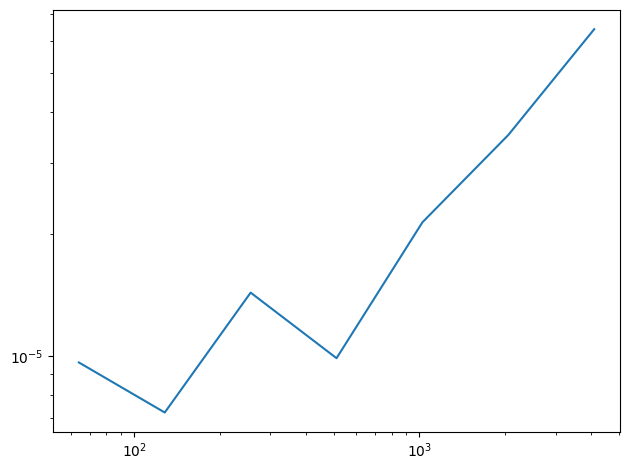

In [7]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

По графику можно увидеть, что эта функция работает быстрее, время её работы пропорционально N * log(N).

Теперь проанализируем dct_iv

In [8]:
def dct_iv(ys, freqs, ts):
  N = len(ys)
  ts = (0.5 + np.arange(N))/N
  fs = (0.5 + np.arange(N))/2
  args = np.outer(ts,fs)
  M = np.cos(PI2*args)
  amps = np.dot(M, ys) / 2
  return amps

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


64
104 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
585 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.16 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
12.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
135 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
157 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
692 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.150071136923382

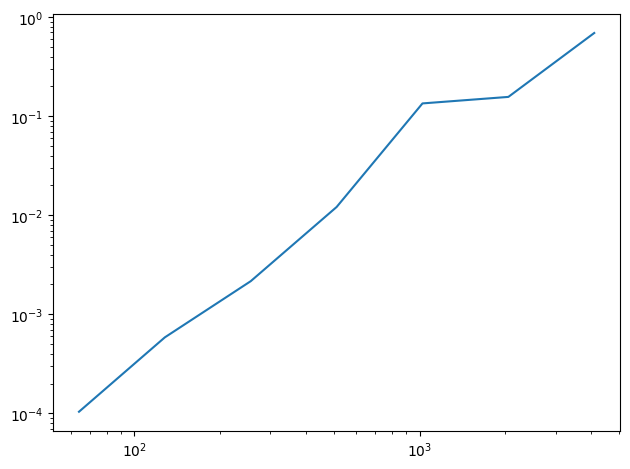

In [11]:
best4 = run_speed_test(ns, dct_iv)
plot_bests(ns, best4)

В итоге получили искривлённую линию с наклоном около 1.9.

# Упражнение 6.2


Oдно из основных применений ДКП - это сжатие звука и изображений.
В простейшей форме ДКП при сжатии работает следующим
образом:
1. Разбивает длинный сигнал на сегменты.
2. Вьчисляет ДКП каждого сегмента.
3. Определяет частотные компоненты с такой амплитудой, что
их не слышно, и удаляет их, сохраняя только оставшиеся частоты
и амплитуды.
4. При воспроизведении сигнала загружает частоты и амплитуды
каждого сегмента и применяет обратное ДКП.
Реализуйте версию этого алгоритма и примените его для записи
музыки или речи. Сколько компонент можно удалить до того, как
разница станет заметной?

Загрузим саму запись и послушаем:

In [12]:
from thinkdsp import read_wave

wave = read_wave('music.wav')
wave.make_audio()

Output hidden; open in https://colab.research.google.com to view.

Извлечем из неё сегмент

In [16]:
segment = wave.segment(start=2, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП сигнала

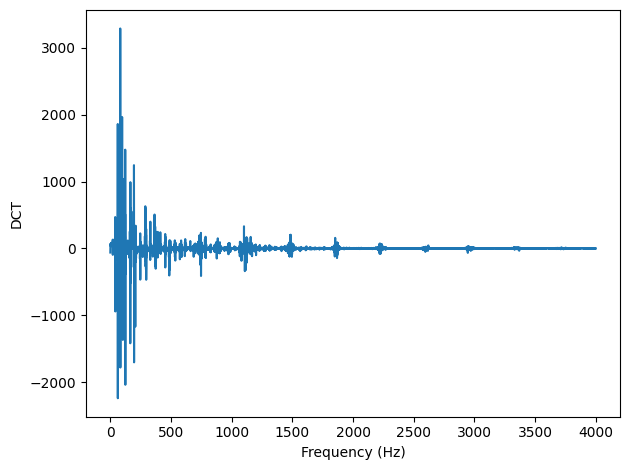

In [17]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Создадим функцию, которая убирает из ДКП частоты со значениями ниже заданного treshold

In [18]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим эту функцию к заданному сигналу

12087	22050	54.816326530612244


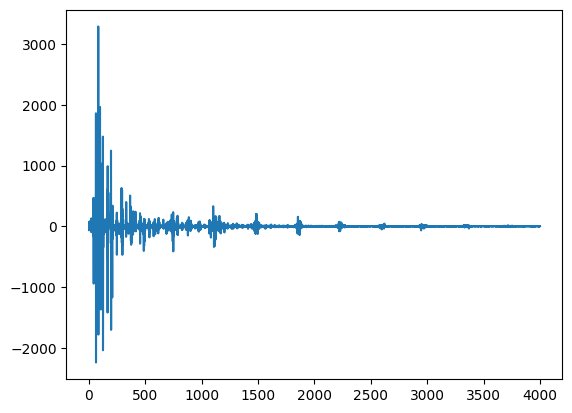

In [19]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=1)
seg_dct.plot(high=4000)

In [20]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Звук остался практически неизменным при сжатии в 85%

Создадим функцию, которая позволит получить спектрограмму ДКП

In [21]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Теперь можно сжать все сегменты ДСП

In [22]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.002)

Выходные данные были обрезаны до нескольких последних строк (5000).
12	1024	1.171875
7	1024	0.68359375
6	1024	0.5859375
5	1024	0.48828125
12	1024	1.171875
8	1024	0.78125
7	1024	0.68359375
13	1024	1.26953125
10	1024	0.9765625
10	1024	0.9765625
12	1024	1.171875
12	1024	1.171875
7	1024	0.68359375
15	1024	1.46484375
5	1024	0.48828125
16	1024	1.5625
12	1024	1.171875
14	1024	1.3671875
10	1024	0.9765625
12	1024	1.171875
9	1024	0.87890625
6	1024	0.5859375
10	1024	0.9765625
6	1024	0.5859375
10	1024	0.9765625
10	1024	0.9765625
4	1024	0.390625
16	1024	1.5625
10	1024	0.9765625
6	1024	0.5859375
6	1024	0.5859375
8	1024	0.78125
9	1024	0.87890625
10	1024	0.9765625
13	1024	1.26953125
12	1024	1.171875
14	1024	1.3671875
11	1024	1.07421875
10	1024	0.9765625
5	1024	0.48828125
7	1024	0.68359375
11	1024	1.07421875
6	1024	0.5859375
9	1024	0.87890625
10	1024	0.9765625
3	1024	0.29296875
6	1024	0.5859375
12	1024	1.171875
11	1024	1.07421875
13	1024	1.26953125
10	1024	0.9765625
8	1024	0.78125
7	1024	0.68359375
6	1

Большинство сегментов удалось сжать на 40-60%

In [23]:
wave2 = spectro.make_wave()
wave2.make_audio()

Output hidden; open in https://colab.research.google.com to view.

Если увеличить сжатие, то становятся заметны шумы

In [24]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.008)

Выходные данные были обрезаны до нескольких последних строк (5000).
51	1024	4.98046875
47	1024	4.58984375
33	1024	3.22265625
34	1024	3.3203125
39	1024	3.80859375
32	1024	3.125
39	1024	3.80859375
35	1024	3.41796875
32	1024	3.125
39	1024	3.80859375
35	1024	3.41796875
37	1024	3.61328125
43	1024	4.19921875
47	1024	4.58984375
33	1024	3.22265625
50	1024	4.8828125
35	1024	3.41796875
46	1024	4.4921875
32	1024	3.125
47	1024	4.58984375
42	1024	4.1015625
39	1024	3.80859375
34	1024	3.3203125
26	1024	2.5390625
34	1024	3.3203125
42	1024	4.1015625
29	1024	2.83203125
42	1024	4.1015625
28	1024	2.734375
25	1024	2.44140625
32	1024	3.125
31	1024	3.02734375
34	1024	3.3203125
40	1024	3.90625
33	1024	3.22265625
42	1024	4.1015625
41	1024	4.00390625
38	1024	3.7109375
34	1024	3.3203125
33	1024	3.22265625
35	1024	3.41796875
37	1024	3.61328125
28	1024	2.734375
33	1024	3.22265625
26	1024	2.5390625
36	1024	3.515625
33	1024	3.22265625
36	1024	3.515625
39	1024	3.80859375
38	1024	3.7109375
44	1024	4.296875
29	1024	2.8

In [25]:
wave2 = spectro.make_wave()
wave2.make_audio()

Output hidden; open in https://colab.research.google.com to view.

# Упражнение 6.3
В репозитории этой книги есть блокнот jupyter под названием
phase.ipynb, в котором исследуется влияние фазы на восприятие
звука. Прочтите этот блокнот и "погоняйте" примеры. Выберите
иной сегмент звука и повторите эксперименты. Можно ли найти некие
общие соотношения в фазовой структуре звука и его восприятии?

Импортируем необходимые библиотеки, загрузим и послушаем саму запись:

In [27]:
if not os.path.exists('100475__iluppai__saxophone-weep.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav

--2024-06-13 17:36:28--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/100475__iluppai__saxophone-weep.wav [following]
--2024-06-13 17:36:28--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/100475__iluppai__saxophone-weep.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071600 (2.0M) [audio/wav]
Saving to: ‘100475__iluppai__saxophone-weep.wav’

100475__iluppai__sa 100%[===================>]   1.98M  --.-KB/s    in 0.01s   

2024-06-13 17:36:28 (1

In [30]:
from thinkdsp import read_wave

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Выделим сегмент из исходной записи:

In [31]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

Напишем функции для вывода амплитуды, углов и waveform заданного спектра

In [32]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase (radian)')

In [33]:
def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

Получим данные для оригинального сегмента

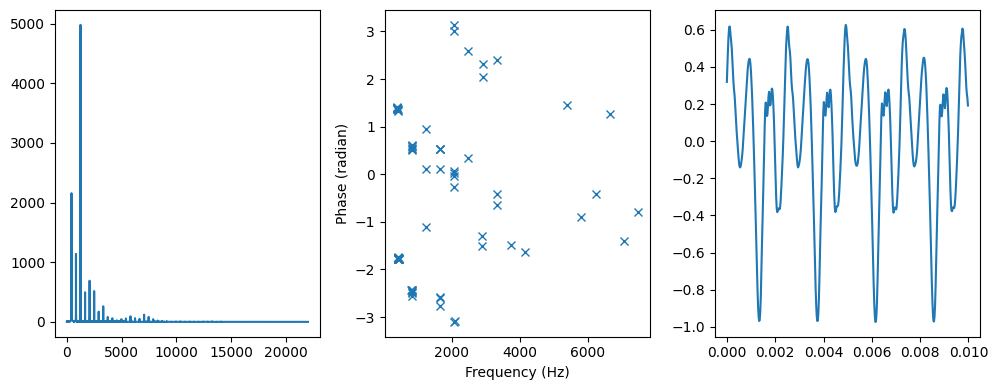

In [34]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Напишем функцию для обнуления всех углов сегмента

In [35]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

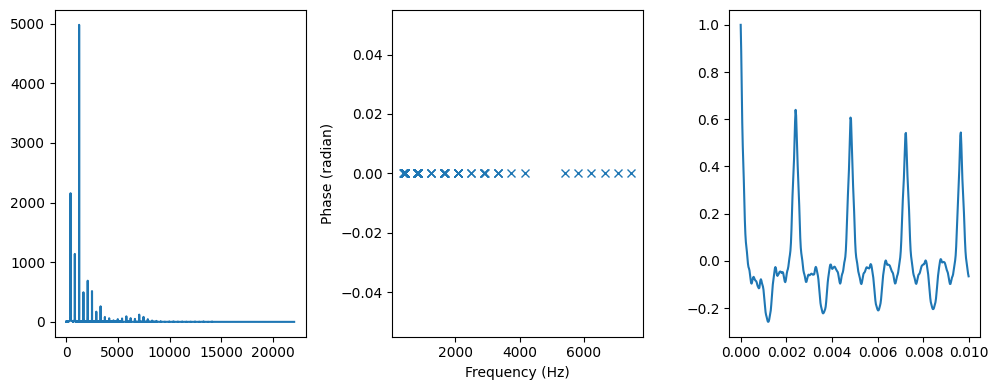

In [36]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

После обнуления углов сегмент звучит намного тише

Теперь напишем функцию для поворота углов на 1 радиан

In [37]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

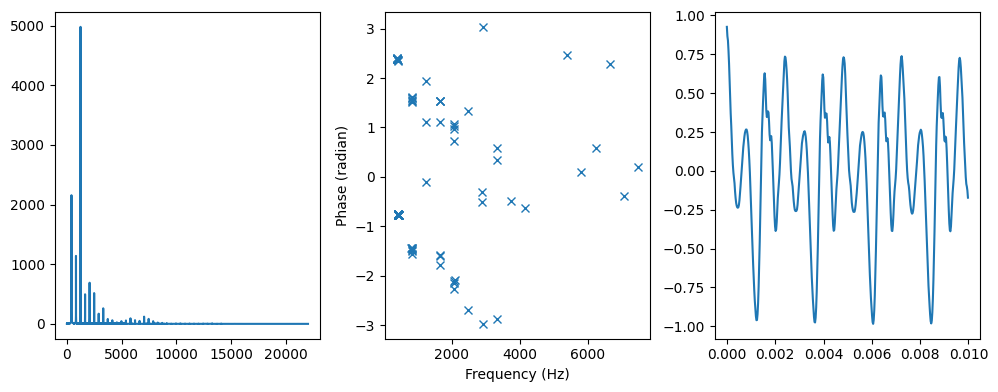

In [38]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

После поворота углов сигнал кажется почти неизменным

Создадим функцию для рандомизации углов

In [39]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

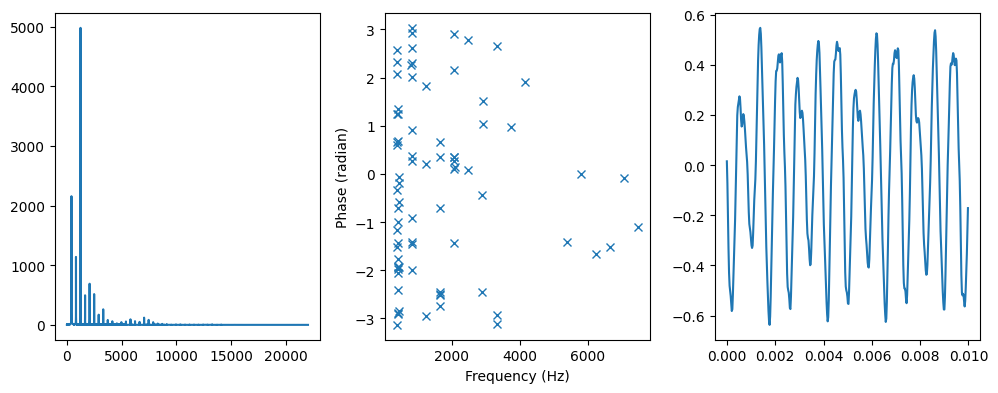

In [40]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

К звуку изначальной записи добавилось эхо